In [2]:
import os
import sys
import copy
sys.path.append("../../FAIR/notebooks")
from plot_fair import *
from oggm import cfg, utils, workflow, graphics, tasks
from oggm.core.flowline import equilibrium_stop_criterion, FileModel
import oggm
import plot_gcm
from functools import partial
from moepy import lowess
import random
import numpy as np
import warnings

import xarray as xr
import pandas as pd
import geopandas as gpd
import plot_gcm
import importlib
import dask
from scipy import optimize
from dask.diagnostics import ProgressBar

from cycler import cycler
import matplotlib as mpl
from matplotlib import colors
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection,HandlerBase
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
dask.config.set({"array.slicing.split_large_chunks": False})

# create cmap
color_list=[colors.to_rgb('#'+c) for c in ["001219","003946","005f73","0a9396","4fb3aa","94d2bd","e9d8a6","ecba53","ee9b00","dc8101","bb3e03","8d210c","5e0314"]]
gcm_cmap = cmap = mpl.colors.ListedColormap(color_list)
custom_cycler = cycler(color=gcm_cmap.colors)

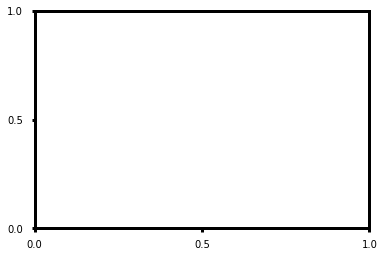

In [3]:
ax= plt.gca()
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =30
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize'] = 20 #30
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.major.pad']='8'
mpl.rcParams['ytick.major.pad']='8'
mpl.rcParams["figure.figsize"] = (15,10)

Before you start, you need to download the results file of the OGGM equilibrium runs for region 11. You can find it here: https://cluster.klima.uni-bremen.de/~julia/OGGM_equilibrium/results

In [4]:
READING_DIR='../data/results'

# read geodetic output
with ProgressBar():
    p = os.path.join(READING_DIR,'11_equilibrium.nc')
    all_ds = xr.open_mfdataset(p, parallel=True)
    
all_ds = all_ds.assign_coords({"region": all_ds.rgi_id.str[6:8]}).equilibrium

order=['CanESM5', 'NorESM2-MM', 'FGOALS-f3-L','BCC-CSM2-MR', 'MRI-ESM2-0','MPI-ESM1-2-HR','ACCESS-CM2', 'EC-Earth3', 'MIROC6','CESM2','GISS-E2-2-H','IPSL-CM6A-LR-INCA','E3SM-1-1','CRU']
ex_2_hot=['FGOALS-f3-L', 'BCC-CSM2-MR', 'MRI-ESM2-0', 'MPI-ESM1-2-HR', 'ACCESS-CM2', 'MIROC6', 'CESM2', 'GISS-E2-2-H','CRU']
all_ds = all_ds.sel(gcm=order)


[########################################] | 100% Completed | 343.27 ms


In [5]:
# remove nan values 
ds = xr.concat([all_ds.sel(gcm=gcm).dropna(dim='year',how='all').dropna(dim='rgi_id',how='any') for gcm in all_ds.gcm.values],dim='gcm')
ds = ds.assign_coords({"region": ds.rgi_id.str[6:8]})

In [6]:
ds_sum = ds.groupby('region').sum(min_count=1)

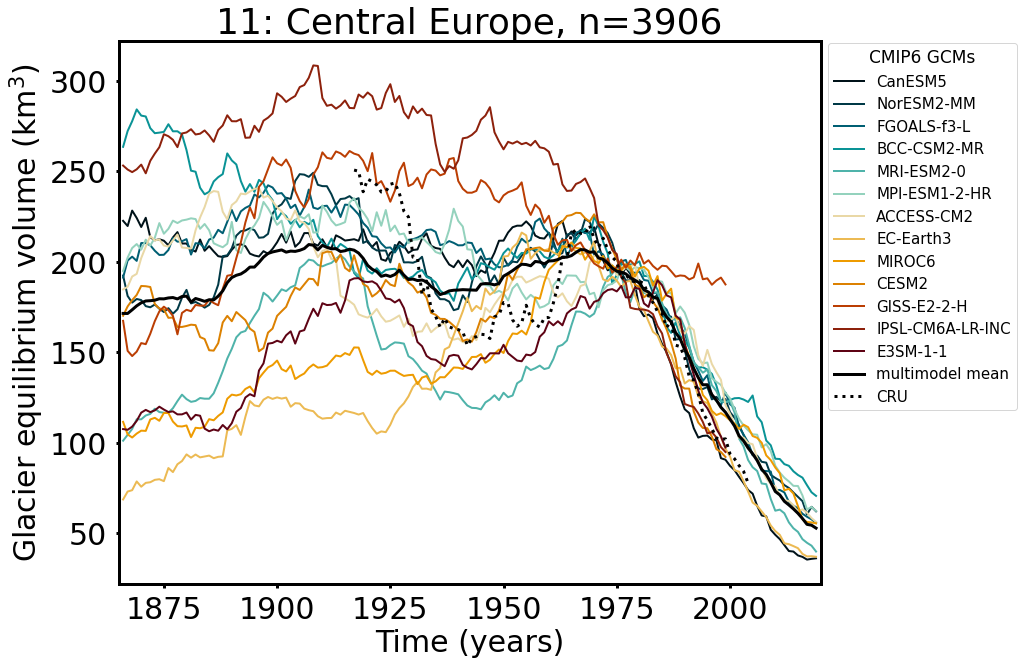

In [7]:
importlib.reload(plot_gcm)

fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('white')
grid = plt.GridSpec(1,1,left=0.15,right=0.8)
ax = fig.add_subplot(grid[0])

plot_gcm.plot_volume_km3(ds_sum,'11', n=len(all_ds.rgi_id.values), ax=ax)
ax.set_title('11: Central Europe, n='+str(len(ds.rgi_id)));
plt.savefig(os.path.join('../plots','Alps','alps_volume_km3.png'),dpi=300);

In [8]:
def convert_km3_to_sle(ds): 
    # convert volume (km^3) to mass (Gt)
    mass = ds*0.9167
    # convert mass (Gt) to sle
    sle = mass*(1 / 361.8)
    return sle    

In [9]:
ds_dt = ds_sum-ds_sum.sel(year=1998)
sle_dt = convert_km3_to_sle(-ds_dt)

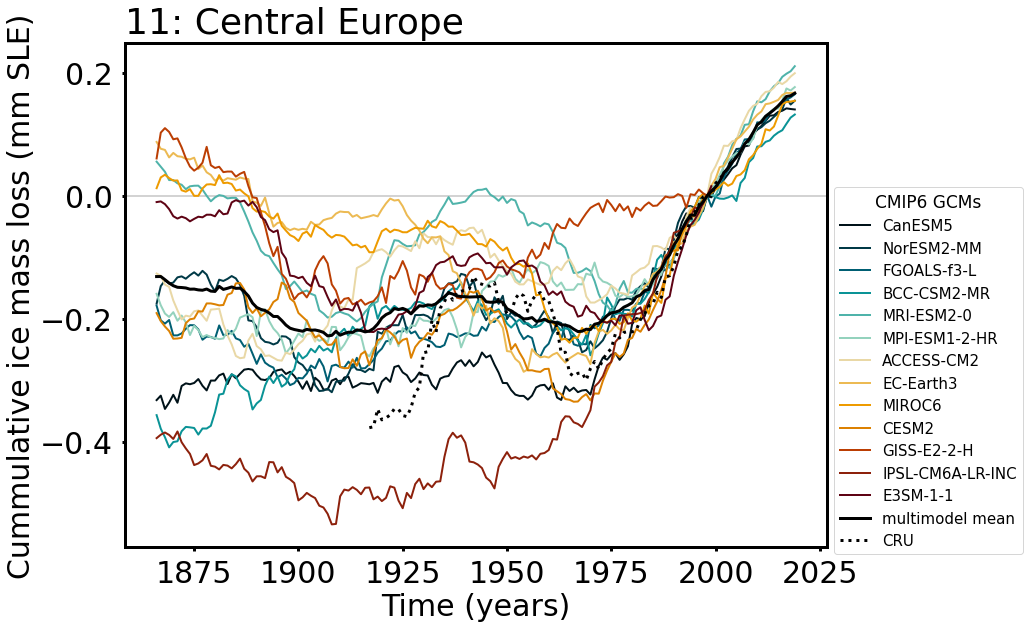

In [10]:
importlib.reload(plot_gcm)

fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('white')
grid = plt.GridSpec(1,1,left=0.15,right=0.8, top=0.825)
ax = fig.add_subplot(grid[0])

plot_gcm.plot_mass_loss_sle(sle_dt, '11', n=len(ds.rgi_id), ax=ax, add_legend=True,lw=2);
plt.savefig(os.path.join('../plots','Alps','alps_SLE.png'),dpi=300);

## Preindustrial temperatures


### Global mean temperature of each gcm
We have calculated the global mean temperature anomalies relative to preindustrial conditions [here](./CMIP6_compute_GMT.ipynb) and only need to load the results:

In [11]:
import xarray as xr
gmt =  xr.open_dataset('../data/results/GMT_anomly.nc').tas
gmt

<xarray.DataArray 'tas' (gcm: 14, time: 185)>
[2590 values with dtype=float64]
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2030 2031 2032 2033 2034
  * gcm      (gcm) object 'CanESM5' 'NorESM2-MM' ... 'E3SM-1-1' 'HadCRUT5'
Attributes:
    description:     Global temperature Anomalies (bias corrected)\n relative...
    units:          °C
    creation_date:  2023-01-06 09:54:00

We need to calculate the 30-year rolling mean: 

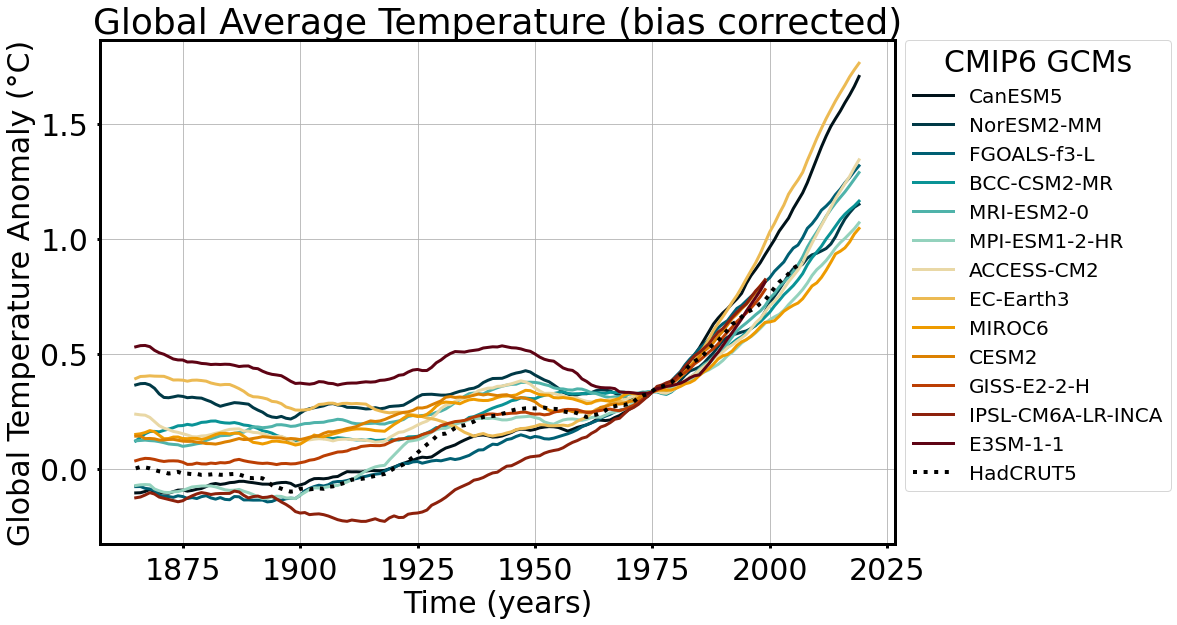

In [12]:
importlib.reload(plot_gcm)

fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('white')
grid = plt.GridSpec(1,1,left=0.1,right=0.75, top=0.825)
ax = fig.add_subplot(grid[0])


ax.set_prop_cycle(plot_gcm.create_color_cycler(3, n=len(order)-1))
gmt.rolling(time=31,center=True).mean().plot(hue='gcm')   
ax.set_title('')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Global Temperature Anomaly (°C)')
ax.set_title('Global Average Temperature (bias corrected)') 
ax.get_legend().set_bbox_to_anchor((1, 1.02))
ax.get_legend().set_title("CMIP6 GCMs")
plt.grid()
plt.savefig(os.path.join('../plots','GMT_CMIP6.png'),dpi=300);

### Wrap GMT data and equlibrium data together

In [13]:
df = gmt.rolling(time=31,center=True).mean().dropna(dim='time', how='all').to_pandas()
df = df.iloc[:-1,1:].T;

df_eq = ds_sum.sel(region='11').to_pandas().drop('CRU').T

def merge_df(gcm):
    d = pd.concat([df.loc[:,gcm], df_eq.loc[:,gcm]],keys=['GMT','equilibrium'],names=gcm,axis=1).to_xarray()
    d = d.assign(year=d.index)
    d = d.assign_coords(gcm=gcm)
    d = d.set_index(index='GMT').rename({'index':'GMT'})
    
    d = d.dropna(dim='GMT')
    return d
gcm_ds = xr.concat([merge_df(gcm) for gcm in df.columns], dim='gcm')

In [14]:
gcm_ds

<xarray.Dataset>
Dimensions:      (GMT: 1919, gcm: 13)
Coordinates:
  * GMT          (GMT) float64 -0.2303 -0.2302 -0.2302 ... 1.708 1.737 1.765
  * gcm          (gcm) <U17 'CanESM5' 'NorESM2-MM' ... 'E3SM-1-1'
Data variables:
    equilibrium  (gcm, GMT) float64 nan nan nan nan nan ... nan nan nan nan nan
    year         (gcm, GMT) float64 nan nan nan nan nan ... nan nan nan nan nan

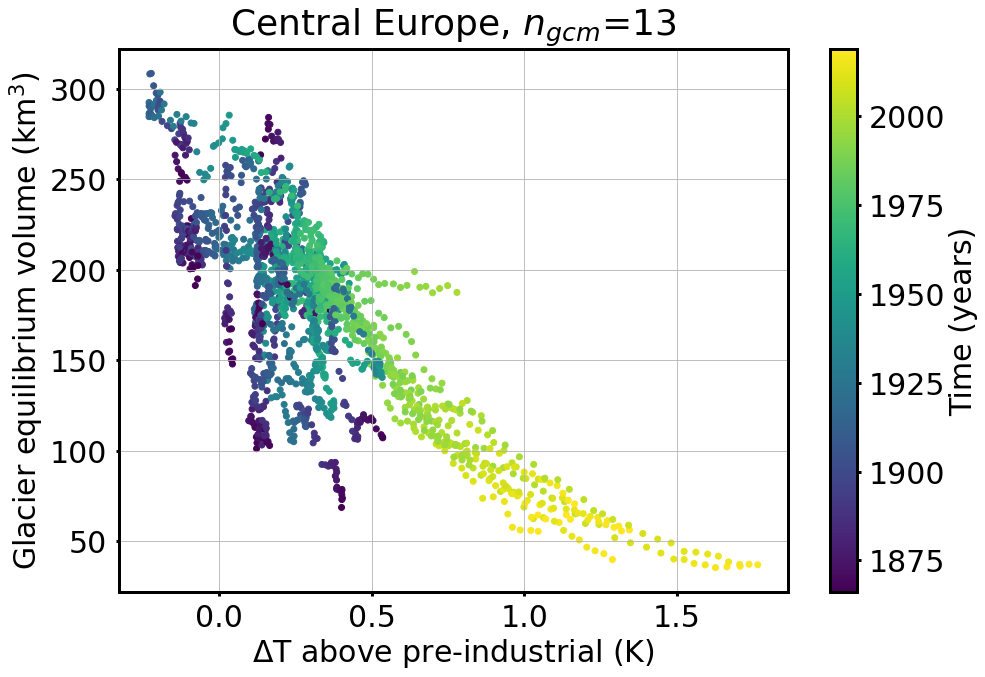

In [15]:
ax=plt.gca()
norm = mpl.colors.Normalize(vmin=1866, vmax=2019)
for gcm in gcm_ds.gcm:
    df_gcm_r = gcm_ds.sel(gcm=gcm).to_pandas().reset_index()
    d = ax.scatter(df_gcm_r.GMT, df_gcm_r.equilibrium, c=df_gcm_r.year, norm=norm)
cb = plt.colorbar(d, label='Time (years)',ticks=[1875,1900,1925,1950,1975,2000])
ax.set_ylabel(r'Glacier equilibrium volume (km$^3$)');
ax.set_xlabel(r'$\Delta$T above pre-industrial (K)');
ax.grid()
ax.set_title(r'Central Europe, $n_{gcm}$=13');
plt.savefig(os.path.join('../plots','Alps','scatter_equilibrium_dT.png'),dpi=300);


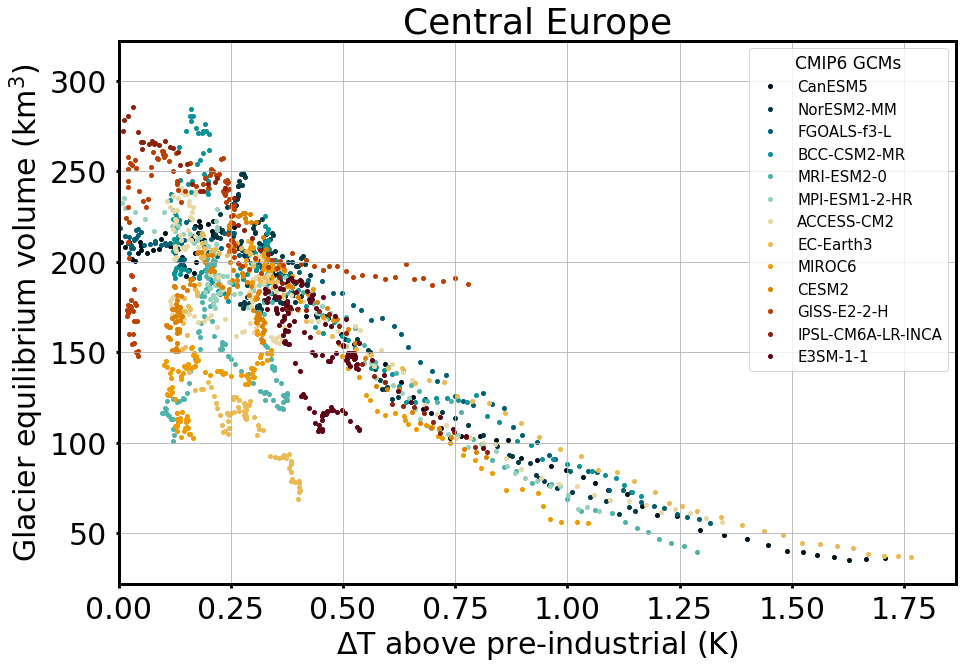

In [16]:
ax = plt.gca()
ax.set_prop_cycle(plot_gcm.create_color_cycler(lw=3,n=13))

# draw points 
ax.set_prop_cycle(plot_gcm.create_color_cycler(lw=3,n=13))
gcm_ds.equilibrium.to_pandas().T.plot(lw=0, marker='o',ax=ax,markersize=4,legend=False,zorder=1,alpha=1)

leg = plt.legend(fontsize=15)
leg.set_title('CMIP6 GCMs',prop={'size':17})

ax.set_ylabel(r'Glacier equilibrium volume (km$^3$)');
ax.set_xlabel(r'$\Delta$T above pre-industrial (K)');
ax.grid()
ax.set_title(r'Central Europe')
ax.set_xlim(0,None)
plt.savefig(os.path.join('../plots','Alps','scatter_equilibrium_dT_gcm.png'),dpi=300);

### Find representative of this dataset 
The data is quite noisy and spaced irregular on the x-axis, which makes some troubles when calculating the median. We need to find a method that smoothes out the noise. Following approaches didn't work that well: 

- rolling median (too large window necessary)
- coarsen median (either too noisy or to edgy)
- piecewise median regression (to edgy)
- gaussian regression (only mean and std larger for higher $\Delta$GMT because of reduced number of datapoints)

#### Remove info about individual gcms  (treat all datapoints equally)
This might be helpfull for the regression

In [17]:
all_df = pd.DataFrame()
for gcm in gcm_ds.gcm:
    df_gcm_r = gcm_ds.sel(gcm=gcm).to_pandas().reset_index()
    all_df = pd.concat([all_df,df_gcm_r.dropna().drop('gcm',axis=1)],ignore_index=True)
all_df = all_df.sort_values(by='GMT')

#### LOWESS regression
This worked best :)

In [18]:
# calculates the quantiles (0.1,0.5,0.9) with LOWESS
df_quantiles = lowess.quantile_model(all_df.GMT.values, all_df.equilibrium.values,qs=[0.1,0.5,0.9],x_pred=np.linspace(-0.25,1.75,100),
                                     frac=0.7, num_fits=20)
df_quantiles.to_csv(os.path.join('../data','results','lowess_equilibrium_over_dT.csv'))

100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


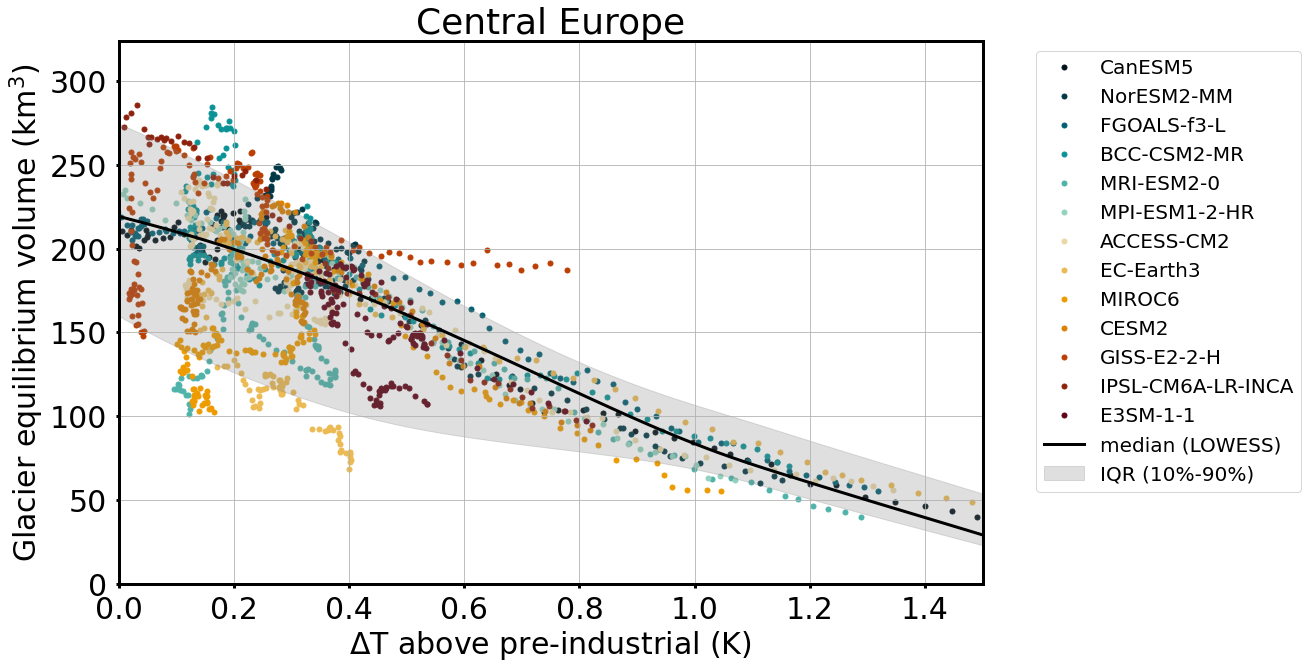

In [19]:
# plot the result
fig = plt.figure(figsize=(20,10))
fig.patch.set_facecolor('white')
grid = plt.GridSpec(1,1,left=0.1,right=0.7)
ax = fig.add_subplot(grid[0])

ax.set_prop_cycle(plot_gcm.create_color_cycler(lw=3,n=13))
gcm_ds.equilibrium.to_pandas().T.plot(lw=0,marker='o',ax=ax,markersize=5,legend=False,zorder=1,alpha=1)

# plot Lowess median
ax.plot(df_quantiles.index, df_quantiles[0.5], color='k', linestyle='-',lw=3, label='median (LOWESS)')

# quantile range
ax.fill_between(df_quantiles.index, df_quantiles[0.1], df_quantiles[0.9], color='grey', alpha=0.25, label='IQR (10%-90%)')

ax.legend(bbox_to_anchor=(1.05, 1))

ax.set_ylim(0)
ax.set_xlim(0,1.5)

ax.set_ylabel(r'Glacier equilibrium volume (km$^3$)');
ax.set_xlabel(r'$\Delta$T above pre-industrial (K)');
ax.grid()
ax.set_title('Central Europe')
plt.savefig(os.path.join('../plots','Alps','lowess_equilibrium_dT.png'),dpi=300);

### Get results from FaIR for all three gases

In [20]:
# ----- absolute Delta GMT values -----
# values by emission year by gas

co2_gmt = pd.read_csv('../../FAIR/data/results/dT_CO2_2100.csv').set_index('Year').loc[1850:2100]
n2o_gmt = pd.read_csv('../../FAIR/data/results/dT_N2O_2100.csv').set_index('Year').loc[1850:2100]
ch4_gmt = pd.read_csv('../../FAIR/data/results/dT_CH4_2100.csv').set_index('Year').loc[1850:2100]
# sum by year
sum_gmt_by_year = co2_gmt.add(ch4_gmt,fill_value=0).add(n2o_gmt, fill_value=0)
sum_gmt = sum_gmt_by_year.sum(axis=1).loc[:2019]

# sum by gas
sum_gmt_by_gas = pd.DataFrame()
sum_gmt_by_gas[r'$CO_2$'] = co2_gmt.sum(axis=1)
sum_gmt_by_gas[r'$CH_4$'] = ch4_gmt.sum(axis=1)
sum_gmt_by_gas[r'$N_2O$'] = n2o_gmt.sum(axis=1)

# ----- percentage values -----

# values by emission year by gas
co2_perc = co2_gmt.divide(sum_gmt_by_year.sum(axis=1),axis=0)
n2o_perc = n2o_gmt.divide(sum_gmt_by_year.sum(axis=1),axis=0)
ch4_perc = ch4_gmt.divide(sum_gmt_by_year.sum(axis=1),axis=0)

sum_perc_by_year = co2_perc.add(n2o_perc,fill_value=0).add(ch4_perc, fill_value=0)

# sum by gas
sum_perc_by_gas = pd.DataFrame()
sum_perc_by_gas[r'$CO_2$'] = co2_perc.sum(axis=1)
sum_perc_by_gas[r'$CH_4$'] = ch4_perc.sum(axis=1)
sum_perc_by_gas[r'$N_2O$'] = n2o_perc.sum(axis=1)


In [21]:
# create colormaps for concentration plot
co2_cmap = create_color_maps(170, ppm_color='conc')
# create colormaps for GMT change plot
T_cmap = create_color_maps(170)

[['546A7B', 5], ['62929E', 10], ['C6C5B9', 2]]
[['9E2A2B', 5], ['BF6535', 10], ['E09F3E', 2]]


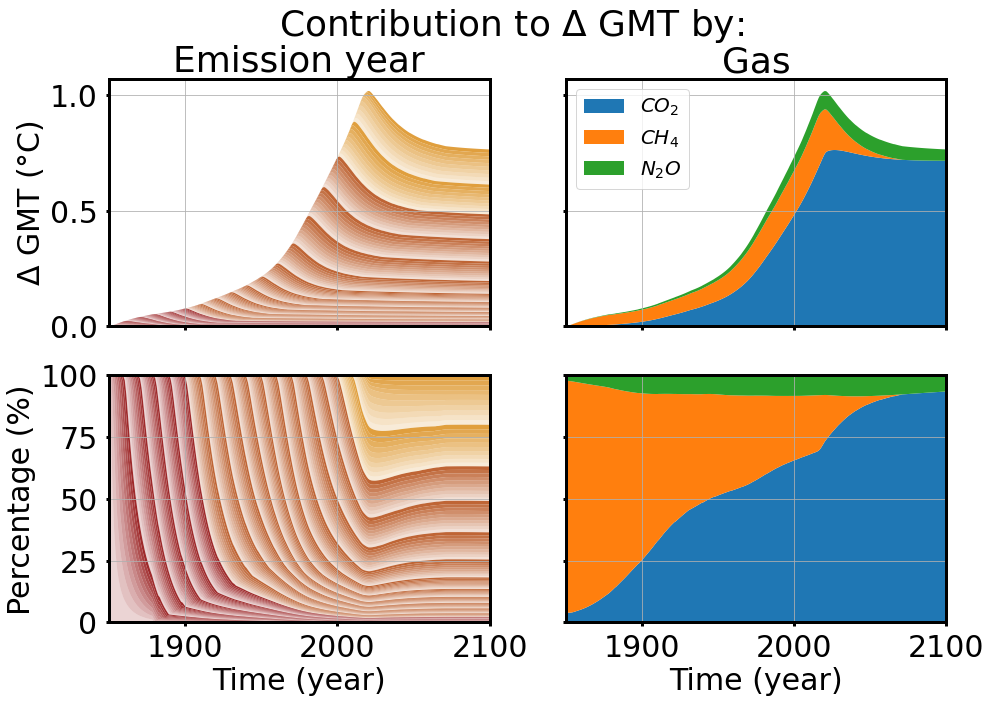

In [22]:
fig,[[ax0,ax1],[ax2,ax3]] = plt.subplots(2,2, sharex=True, sharey='row')

# absolute values
sum_gmt_by_year.plot.area(legend=False,cmap=T_cmap, lw=0, ax=ax0)
sum_gmt_by_gas.plot.area(lw=0, ax=ax1)

# percentage values
(sum_perc_by_year*100).plot.area(legend=False,cmap=T_cmap,lw=0,ax=ax2)
(sum_perc_by_gas*100).plot.area(lw=0, ax=ax3, legend=False)

ax0.set_title('Emission year')
ax1.set_title('Gas')
ax0.set_ylabel(r'$\Delta$ GMT (°C)')
ax2.set_ylabel('Percentage (%)')
ax2.set_xlabel('Time (year)')
ax3.set_xlabel('Time (year)')

ax0.set_xlim(1850,2100)
ax0.set_ylim(0,None)
ax2.set_ylim(0,100)

ax0.grid(); ax1.grid(); ax2.grid(); ax3.grid()

fig.suptitle(r'Contribution to $\Delta$ GMT by: ');

### Wrap FaIR and OGGM results together

In [23]:
x_resampled = np.insert(sum_gmt.values,0,0)
# resample OGGM results to emission bins
df_resampled = df_quantiles.reindex(df_quantiles.index.union(x_resampled)).interpolate('values').loc[x_resampled]
# calculate glacier mass changes 
df_diff = -df_resampled.diff().iloc[1:]
df_diff.loc[:,'Year']=sum_gmt.index
df_diff.Year = df_diff.Year.astype('int')
df_diff = df_diff.reset_index().set_index('Year')
# convert km^3 to Gt
df_diff = df_diff* 0.9167

In [24]:
# calculate responsibility of glacier mass loss in Central Europe by yearly total emissions (CO2+CH4+N2O)
dM_response_by_yr = sum_gmt_by_year.mul(df_diff.loc[:,0.5].cumsum(),axis=0)

# caclulate responsibility of glacier mass loss in Central Europe by yearly CO2 emissions
dM_response_by_co2 = co2_perc.mul(df_diff.loc[:,0.5].cumsum(),axis=0)
# caclulate responsibility of glacier mass loss in Central Europe by yearly CH4 emissions
dM_response_by_ch4 = ch4_perc.mul(df_diff.loc[:,0.5].cumsum(),axis=0)
# caclulate responsibility of glacier mass loss in Central Europe by yearly N2O emissions
dM_response_by_n2o = n2o_perc.mul(df_diff.loc[:,0.5].cumsum(),axis=0)

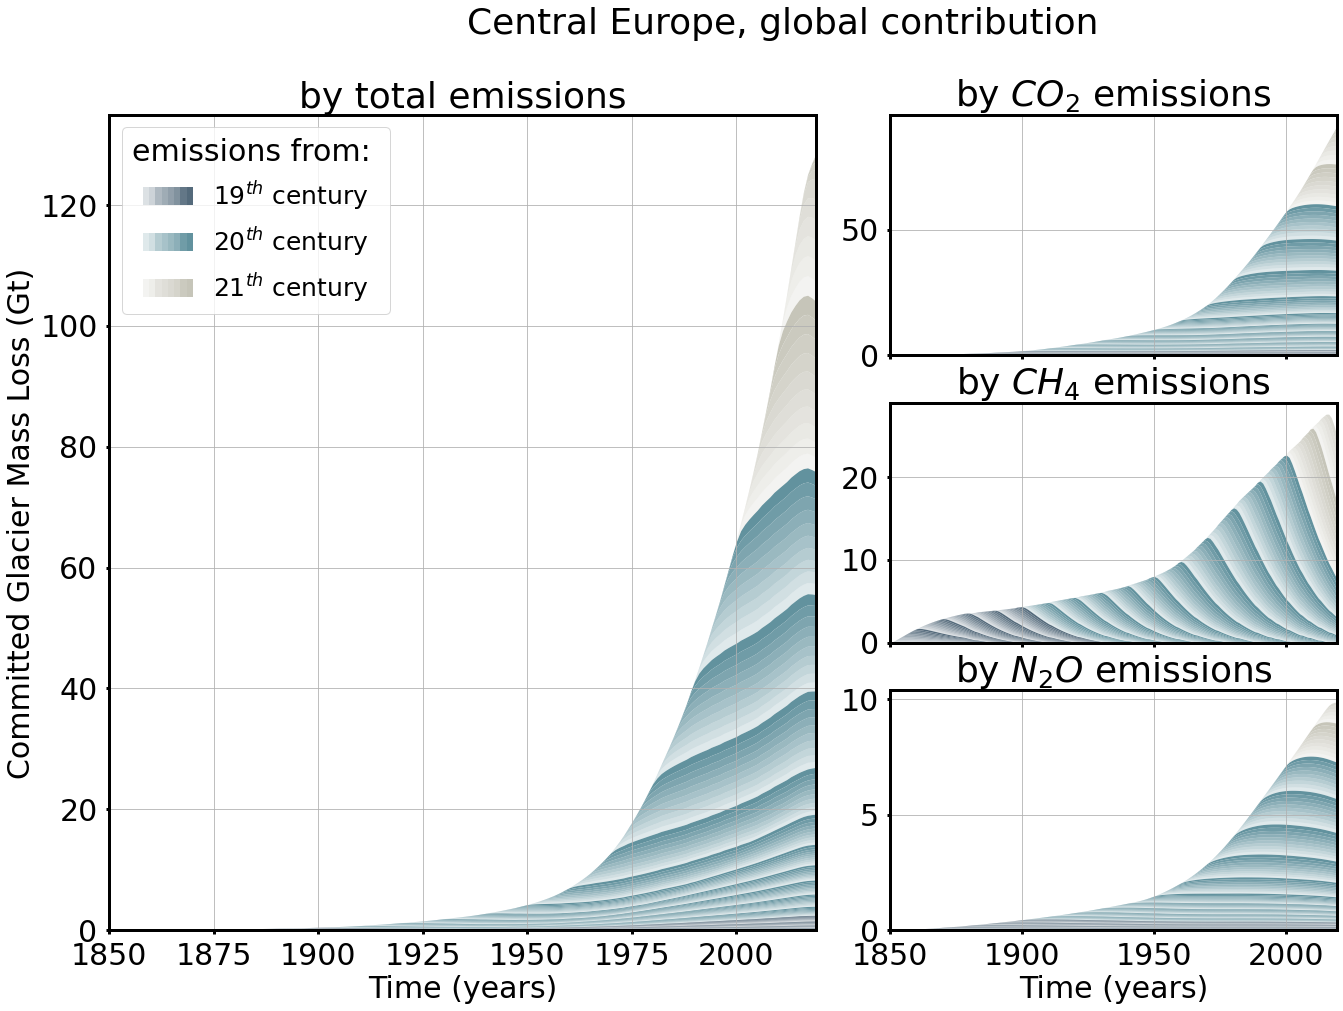

In [25]:
fig = plt.figure(figsize=(22, 15))
grid = plt.GridSpec(3, 5, hspace=0.2, wspace=0.4, right=0.85, left=0.075)
ax0 = plt.subplot(grid[:, :3])
ax1 = plt.subplot(grid[0, 3:])
ax2 = plt.subplot(grid[1, 3:], sharex=ax1)
ax3 = plt.subplot(grid[2, 3:], sharex=ax1)

dM_response_by_yr.plot.area(legend=False,cmap=co2_cmap, linewidth=0,ax=ax0)
dM_response_by_co2.plot.area(legend=False,cmap=co2_cmap, linewidth=0,ax=ax1)
dM_response_by_ch4.plot.area(legend=False,cmap=co2_cmap, linewidth=0,ax=ax2)
dM_response_by_n2o.plot.area(legend=False,cmap=co2_cmap, linewidth=0,ax=ax3)

ax0.set_xlim(1850,2019)
ax1.set_xlim(1850,2019)
ax0.set_ylim(0,None)
ax1.set_ylim(0,None)
ax0.set_title('by total emissions')
ax1.set_title(r'by $CO_2$ emissions')
ax2.set_title(r'by $CH_4$ emissions')
ax3.set_title(r'by $N_2O$ emissions')
ax0.set_xlabel('Time (years)')
ax3.set_xlabel('Time (years)')
ax0.set_ylabel(r'Committed Glacier Mass Loss (Gt)');
plt.suptitle('Central Europe, global contribution')

# legend
cmap_labels = [r'19$^{th}$ century', r'20$^{th}$ century', r'21$^{th}$ century']
cmaps=[plot_gcm.color_to_cmap("546A7B"),plot_gcm.color_to_cmap("62929E"),plot_gcm.color_to_cmap("C6C5B9")]
# create proxy artists as handles:
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, 
                       [plot_gcm.HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
ax0.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,  loc=0,
           fontsize=25, title= r'emissions from: ')

ax0.grid(); ax1.grid(); ax2.grid(); ax3.grid();
plt.savefig(os.path.join('../plots','Alps','mass_loss_by_yr_gas.png'),dpi=300);

## Calculate responsibility of individual countries


In [26]:
co2_perc = pd.read_csv('../../FAIR/data/PRIMAP/primap_co2_perc.csv', index_col=0)
ch4_perc = pd.read_csv('../../FAIR/data/PRIMAP/primap_ch4_perc.csv', index_col=0)
n2o_perc = pd.read_csv('../../FAIR/data/PRIMAP/primap_n2o_perc.csv', index_col=0)

In [27]:
co2_perc

,yr_1850,yr_1851,yr_1852,yr_1853,yr_1854,yr_1855,yr_1856,yr_1857,yr_1858,yr_1859,...,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,yr_2016,yr_2017,yr_2018,yr_2019
ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000077,0.000074,0.000039,0.000025,0.000025,0.000026,0.000025,0.000026,0.000027,0.000028
AFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000265,0.000367,0.000305,0.000254,0.000231,0.000234,0.000203,0.000194,0.000196,0.000270
AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000719,0.000731,0.000770,0.000758,0.001080,0.000829,0.000866,0.000836,0.000765,0.000746
AIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000005,0.000004,0.000004,0.000003,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
ALB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000180,0.000197,0.000186,0.000190,0.000207,0.000177,0.000177,0.000202,0.000185,0.000196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000007,0.000007,0.000007,0.000007,0.000010
YEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000685,0.000675,0.000680,0.000914,0.000872,0.000467,0.000377,0.000359,0.000562,0.000569
ZAF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013670,0.013639,0.012878,0.013112,0.013778,0.013105,0.013257,0.013333,0.012632,0.012845
ZMB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000081,0.000085,0.000105,0.000112,0.000121,0.000124,0.000135,0.000184,0.000195,0.000196


In [28]:
def dT_per_country_gas(iso, dM_response_by_gas, perc_df):
    return dM_response_by_gas*perc_df.loc[iso]
def dT_per_country(iso):
    return dT_per_country_gas(iso,dM_response_by_co2, co2_perc).add(dT_per_country_gas(iso,dM_response_by_n2o, n2o_perc), fill_value=0).add(dT_per_country_gas(iso,dM_response_by_ch4, ch4_perc), fill_value=0)

In [29]:
def plot_dT_per_country(iso):
    df = dT_per_country(iso)
    
    fig = plt.figure(figsize=(22, 15))
    grid = plt.GridSpec(3, 5, hspace=0.5, wspace=0.6, left=0.15)
    ax1 = plt.subplot(grid[:, :3])
    ax2 = plt.subplot(grid[0, 3:])
    ax3 = plt.subplot(grid[1, 3:], sharex=ax2)
    ax4 = plt.subplot(grid[2, 3:], sharex=ax2)

    df.loc[:2100,:].plot.area(legend=False, linewidth=0,ax=ax1,cmap=co2_cmap)
    dT_per_country_gas(iso,dM_response_by_co2, co2_perc).plot.area(legend=False, linewidth=0,ax=ax2,cmap=co2_cmap)
    dT_per_country_gas(iso,dM_response_by_ch4, ch4_perc).plot.area(legend=False, linewidth=0,ax=ax3,cmap=co2_cmap)
    dT_per_country_gas(iso,dM_response_by_ch4, n2o_perc).plot.area(legend=False, linewidth=0,ax=ax4,cmap=co2_cmap)
    
    ax1.axvline(2019,linestyle=':',c='k') 
    ax2.axvline(2019,linestyle=':',c='k')  
    ax3.axvline(2019,linestyle=':',c='k')  
    ax4.axvline(2019,linestyle=':',c='k')  

    ax1.set_xlim(1850,2019)
    ax2.set_xlim(1850,2019)
    
    ax1.set_ylim(0,None)
    ax2.set_ylim(0,None)
    ax3.set_ylim(0,None)
    ax4.set_ylim(0,None)
    
    ax1.ticklabel_format(axis='y', style='sci',scilimits=(-4,6))
    ax2.ticklabel_format(axis='y', style='sci',scilimits=(-2,6))
    ax3.ticklabel_format(axis='y', style='sci',scilimits=(-2,6))
    ax4.ticklabel_format(axis='y', style='sci',scilimits=(-2,6))
    
    ax1.tick_params(axis='both', which='major', pad=15)
    ax1.set_title('by total emissions')
    ax2.set_title(r'by $CO_2$ emissions')
    ax3.set_title(r'by $CH_4$ emissions')
    ax4.set_title(r'by $N_2O$ emissions')
    
    ax1.set_ylabel(r'Committed Glacier Mass Loss (Gt)')
    ax1.set_xlabel('Time (years)')

    
    plt.suptitle(r'Central Europe, contribution from '+ coco.convert(iso,to='name_short')+', '+iso)
    
    # legend
    cmap_labels = [r'19$^{th}$ century', r'20$^{th}$ century', r'21$^{th}$ century']
    cmaps=[plot_gcm.color_to_cmap("546A7B"),plot_gcm.color_to_cmap("62929E"),plot_gcm.color_to_cmap("C6C5B9")]
    # create proxy artists as handles:
    cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
    handler_map = dict(zip(cmap_handles, 
                           [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
    
    ax1.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,  loc=0,
           fontsize=25, title= r'emissions from: ')

    ax1.grid(); ax2.grid(); ax3.grid(); ax4.grid();
    plt.savefig(os.path.join('../plots/Alps/countries','dM_responsibility'+iso+'.png'))
    plt.close()
plot_dT_per_country('DEU')

In [ ]:
non_iso3=['EARTH','NONANNEXI','ANNEXI','BASIC','EU27BX','LDC','UMBRELLA','AOSIS']
i=0
for iso3 in co2_perc.index.union(n2o_perc.index).union(ch4_perc.index).drop(non_iso3):
    i+=1
    try:
        plot_dT_per_country(iso3)
    except:
        pass
    print(i)